## **Building Marketplace Recommendation System**

### Introduction

When shopping for clothing and apparel online, many consumers find themselves having to maneuver to multiple webpages and landing sites to find items they like for comparison. 
Our objective is a reduce consumer hassle of browsing to different pages by developing a recommender system based on consumer’s current product image and providing similar recommendations and links to direct them to their desired page. 

Image based recommendation will help to recommend the most similar product based on customers browsing behaviors. To provide such product recommendations to deliver the most revelent contents and improve customers engagement on the platform, so that it can help business to boost sales and revenue and maintain brand experiences.

### Project Content

* [Amazon Product Dataset](#Amazon-Product-Dataset)
* [Exploratory Data Analysis](#Exploratory-Data-Analysis)
* [Image Embedding](#Image-Embedding)
* [Get Recommendations](#Get-Recommendations)

<a name="Install-the-Libraries"></a>
## Install the Libraries


In [ ]:
import tarfile 
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib.image as img
import pandas as pd
import cv2
import tensorflow as tf
import warnings
import seaborn as sns

<a name="Amazon-Product-Dataset"></a>
## Amazon Product Dataset

The dataset downloaded from *Amazon Berkeley Objects Dataset*, it contains Product meta data, Catalog image, 360º Images and 3D Models.

For this project, we will only use the Product meta data and Catalag image.
- Product meta data contains 147,702 product listing, includes 28 product features. For this project, we will only use the following features `brand`, `color`, `item_id`, `item_name`, `product_type`, `country`, `marketplace`, `main_image_id`.
- Catalog image contains 398,212 images, it is a gzip-compressed comma-separated value (CSV) file with the following columns: `image_id`, `height`, `width`, and `path`. 

We will download the data directly from https://amazon-berkeley-objects.s3.amazonaws.com/index.html#


### Data Download

In [ ]:
! wget P https://amazon-berkeley-objects.s3.amazonaws.com/archives/abo-images-small.tar
! wget P https://amazon-berkeley-objects.s3.amazonaws.com/archives/abo-listings.tar

--2022-05-08 23:15:26--  http://p/
Resolving p (p)... failed: Name or service not known.
wget: unable to resolve host address ‘p’
--2022-05-08 23:15:26--  https://amazon-berkeley-objects.s3.amazonaws.com/archives/abo-images-small.tar
Resolving amazon-berkeley-objects.s3.amazonaws.com (amazon-berkeley-objects.s3.amazonaws.com)... 52.217.66.220
Connecting to amazon-berkeley-objects.s3.amazonaws.com (amazon-berkeley-objects.s3.amazonaws.com)|52.217.66.220|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3253391360 (3.0G) [application/x-tar]
Saving to: ‘abo-images-small.tar’

abo-images-small.ta 100%[===================>]   3.03G  30.6MB/s    in 1m 41s  

2022-05-08 23:17:07 (30.8 MB/s) - ‘abo-images-small.tar’ saved [3253391360/3253391360]

FINISHED --2022-05-08 23:17:07--
Total wall clock time: 1m 41s
Downloaded: 1 files, 3.0G in 1m 41s (30.8 MB/s)
--2022-05-08 23:17:07--  http://p/
Resolving p (p)... failed: Name or service not known.
wget: unable to resolve hos

#### Product Meta Data

In [ ]:
imagetar = tarfile.open('/content/abo-images-small.tar')
imagetar.extractall('./smallpics')
listingtar = tarfile.open('/content/abo-listings.tar')
listingtar.extractall('./listings')
imagetar.close()
listing = pd.read_json('/content/listings/listings/metadata/listings_0.json.gz', lines= True)
listing = listing[['brand', 'color','item_id','item_name','product_type','country','marketplace','main_image_id',]]
listing.head(3)

,brand,color,item_id,item_name,product_type,country,marketplace,main_image_id
0,"[{'language_tag': 'nl_NL', 'value': 'find.'}]","[{'language_tag': 'nl_NL', 'value': 'Veelkleur...",B06X9STHNG,"[{'language_tag': 'nl_NL', 'value': 'Amazon-me...",[{'value': 'SHOES'}],NL,Amazon,81iZlv3bjpL
1,"[{'language_tag': 'es_MX', 'value': 'AmazonBas...","[{'language_tag': 'es_MX', 'value': 'White Pow...",B07P8ML82R,"[{'language_tag': 'es_MX', 'value': '22"" Botto...",[{'value': 'HARDWARE'}],MX,Amazon,619y9YG9cnL
2,"[{'language_tag': 'en_AE', 'value': 'AmazonBas...","[{'language_tag': 'en_AE', 'value': 'Transluce...",B07H9GMYXS,"[{'language_tag': 'en_AE', 'value': 'AmazonBas...",[{'value': 'MECHANICAL_COMPONENTS'}],AE,Amazon,81NP7qh2L6L


#### Catalog Image

In [ ]:
image_doc = pd.read_csv('/content/smallpics/images/metadata/images.csv.gz')
image_doc.head(5)

,image_id,height,width,path
0,010-mllS7JL,106,106,14/14fe8812.jpg
1,01dkn0Gyx0L,122,122,da/daab0cad.jpg
2,01sUPg0387L,111,111,d2/d2daaae9.jpg
3,1168jc-5r1L,186,186,3a/3a4e88e6.jpg
4,11RUV5Fs65L,30,500,d9/d91ab9cf.jpg


#### Data Preparation

In [ ]:
def pasring(ls):
  if type(ls) == list:
    if 'standardized_value' in ls[0].keys():
      value = ls[0]['standardized_value']
    else:
      if 'value' in ls[0].keys():
        value = ls[0]['value']
      else:
        value = None
  else:
    return ls
  return value

In [ ]:
listings = os.listdir('./listings/listings/metadata')
dfs = []
for i in listings:
  path = '/content/listings/listings/metadata/' + i
  listing = pd.read_json(path, lines= True)
  listing = listing[['brand', 'color','item_id','item_name','product_type','country','marketplace','main_image_id',]]
  for column in ['brand','color', 'item_name','product_type']:
    column_parsing = listing[column].apply(pasring)
    listing[column] = column_parsing
  dfs.append(listing)

all_data = pd.concat(dfs)
all_data.head(3)

,brand,color,item_id,item_name,product_type,country,marketplace,main_image_id
0,Amazon Brand - Solimo,multi-colored,B07RB6T5NR,Amazon Brand - Solimo Designer Dream Printed H...,CELLULAR_PHONE_CASE,IN,Amazon,71nXwOmG3UL
1,find.,Burgundy Polito,B06XG4RFTV,"find. Suede Brogues, Red (Burgundy High Shine)...",SHOES,GB,Amazon,81VSs7tFlJL
2,Amazon Brand - Solimo,multi-colored,B0853XKWMX,Amazon Brand - Solimo Designer Auto Yellow Pat...,CELLULAR_PHONE_CASE,IN,Amazon,71TPK7YiRYL


In [ ]:
images = os.listdir('/content/smallpics/images/small')
num_images = 0
for each_folder in images:
  each_folder_all_images = os.listdir('/content/smallpics/images/small/' + each_folder)
  num_images += len(each_folder_all_images)
print("Number of images:", num_images)
print('Number of listings:' ,len(all_data))


Number of images: 398212
Number of listings: 147702


Join image data with product meta data using Image id


In [ ]:
listing_data_with_image = pd.merge(all_data, image_doc, how = 'left', left_on = 'main_image_id', right_on = 'image_id')
listing_data_with_image = listing_data_with_image.dropna(subset = ['path'])
listing_data_with_image.head(5)

,brand,color,item_id,item_name,product_type,country,marketplace,main_image_id,image_id,height,width,path
0,Amazon Brand - Solimo,multi-colored,B07RB6T5NR,Amazon Brand - Solimo Designer Dream Printed H...,CELLULAR_PHONE_CASE,IN,Amazon,71nXwOmG3UL,71nXwOmG3UL,1000.0,1000.0,f3/f3a84254.jpg
1,find.,Burgundy Polito,B06XG4RFTV,"find. Suede Brogues, Red (Burgundy High Shine)...",SHOES,GB,Amazon,81VSs7tFlJL,81VSs7tFlJL,2560.0,1970.0,b6/b6ceb52f.jpg
2,Amazon Brand - Solimo,multi-colored,B0853XKWMX,Amazon Brand - Solimo Designer Auto Yellow Pat...,CELLULAR_PHONE_CASE,IN,Amazon,71TPK7YiRYL,71TPK7YiRYL,1625.0,850.0,d0/d0c9994d.jpg
3,Amazon Brand - Solimo,multi-colored,B081HN7XHX,Amazon Brand - Solimo Designer Blue Pattern Al...,CELLULAR_PHONE_CASE,IN,Amazon,61l9bYzdDAL,61l9bYzdDAL,1444.0,755.0,5f/5f4dce54.jpg
4,Amazon Brand - Solimo,Others,B07TC5F6NF,Amazon Brand - Solimo Designer Random White Pa...,CELLULAR_PHONE_CASE,IN,Amazon,81+FNFmrJML,81+FNFmrJML,2200.0,1879.0,b4/b462cc51.jpg


Let's see what the product images looks like: 

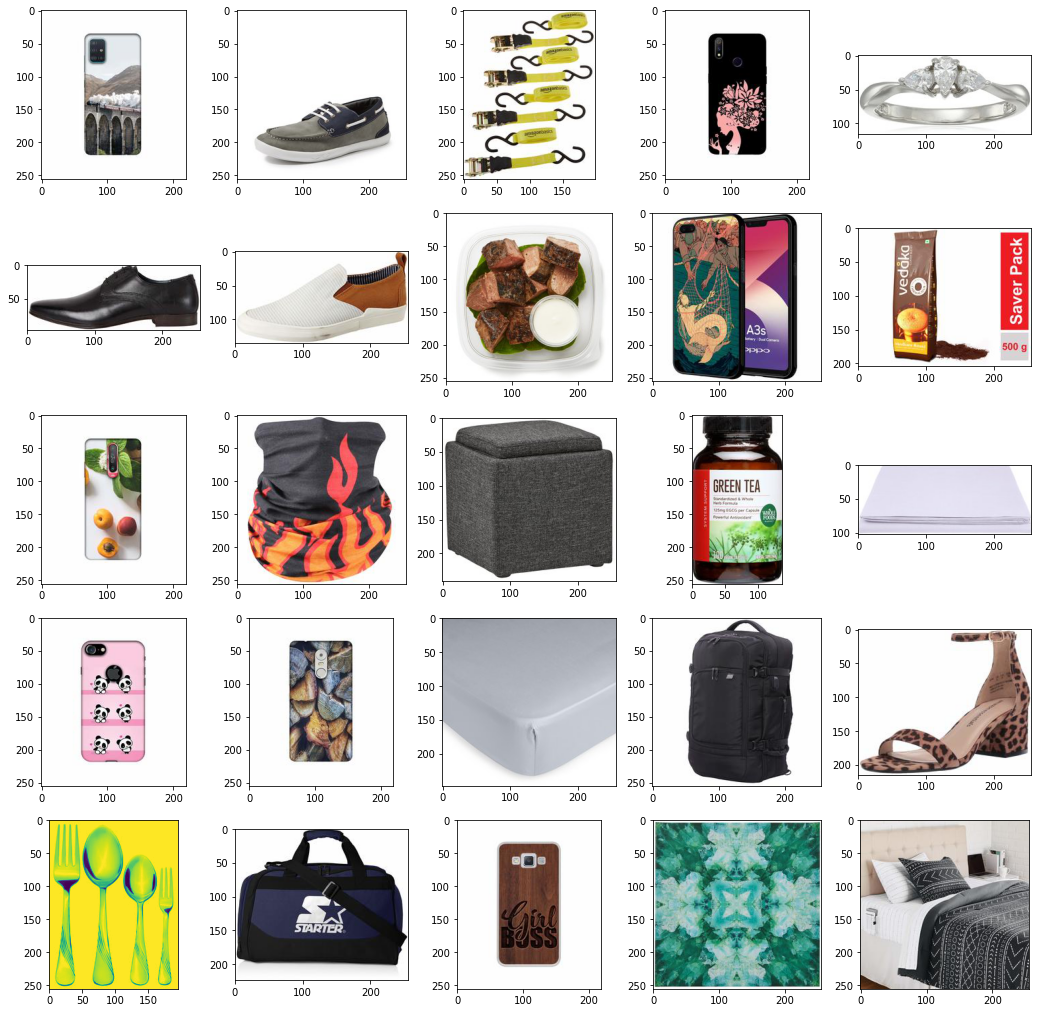

In [ ]:
pics = listing_data_with_image['path'][25:50]
default_path = '/content/smallpics/images/small/'
fig = plt.figure(figsize=(18,18))
for i in range(len(pics.index)):
  fig.add_subplot(5,5,i+1)
  image = img.imread(default_path+ pics[pics.index[i]])
  plt.imshow(image)
plt.show()

#### Check with null values:

There are 31,327 image color is null.

In [ ]:
listing_data_with_image.isnull().sum()

brand               59
color            31327
item_id              0
item_name            0
product_type         0
country              0
marketplace          0
main_image_id        0
image_id             0
height               0
width                0
path                 0
dtype: int64

<a name="Exploratory-Data-Analysis"></a>
## Exploratory Data Analysis

1. [Numerical Variables](#Numerical-Variables)
  * [Height vs. Width](#Height-vs.-Width)

2. [Categorical Variables](#Categorical-Variables)
  * [Brand Types](#Brand-Types)
  * [Product Types](#Product-Types)
  * [Product Colors](#Product-Colors)
  * [Countries](#Countries)
  * [Marketplace](#Marketplace)

<a name="Numerical-Variables"></a>
## Numerical Variables

<a name="Height-vs.-Width"></a>
### Height vs. Width

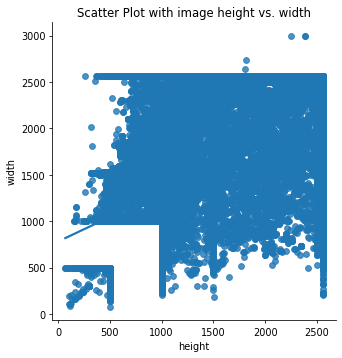

In [ ]:
plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':70})
sns.lmplot(x='height', y='width', data = listing_data_with_image)
plt.title("Scatter Plot with image height vs. width");

###### Based on the height vs. width scatter plot, as height increases then width increases as well.

<a name="Categorical-Variables"></a>
## Categorical Variables

<a name="Brand-Types"></a>
### Brand Types

#### Top five frequency brand products

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


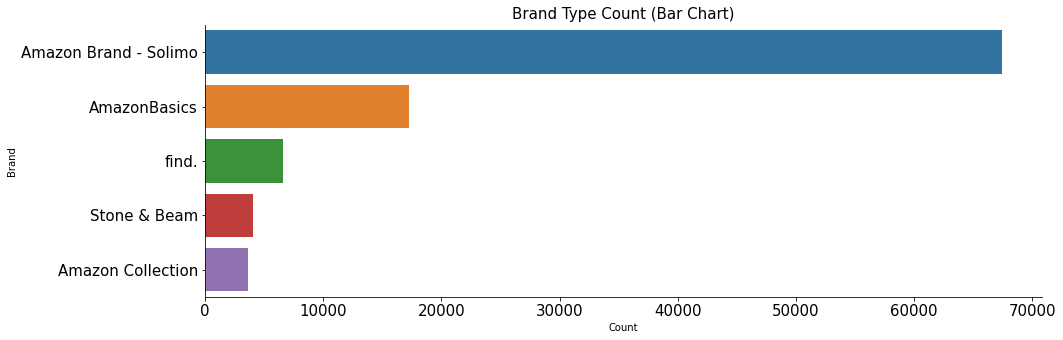

In [ ]:
top5_brand = listing_data_with_image['brand'].value_counts()[:5]
fig, ax = plt.subplots()
fig.set_size_inches(15, 5)
sns.barplot(top5_brand.values, top5_brand.index)
ax.set_xlabel('Count', fontsize = 10)
ax.set_ylabel('Brand', fontsize = 10)
ax.set_title('Brand Type Count (Bar Chart)', fontsize = 15)
ax.tick_params(labelsize = 15)
sns.despine()

##### Based on the top 5 frequency brand types, Amazon Brand (Solimo) is the largest proportion in brand type to compare others, with more than 60,000 listings

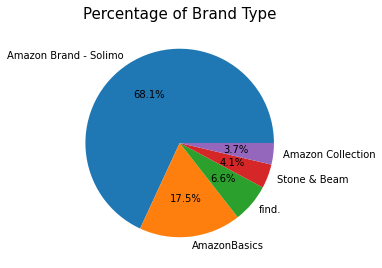

In [ ]:
plt.figure(figsize = (20, 10))
df1 = listing_data_with_image[listing_data_with_image['brand'].isin(top5_brand.index)]
plt.subplots_adjust(left = 0, bottom = 0.5, right = 0.9, top = 0.9, wspace = 0.5, hspace = 0.8)
plt.subplot(141)
plt.title("Percentage of Brand Type", fontsize = 15)
df1["brand"].value_counts().plot.pie(autopct = "%1.1f%%", ylabel = "")

<a name="Product-Types"></a>
### Product Types

###Top five frequency product types

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


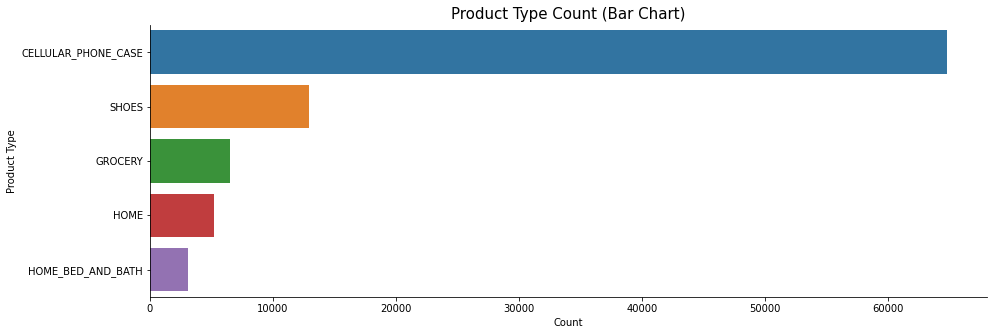

In [ ]:
top5_type = listing_data_with_image['product_type'].value_counts()[:5]
df2 = listing_data_with_image[listing_data_with_image['product_type'].isin(top5_type.index)]
fig, ax = plt.subplots()
fig.set_size_inches(15, 5)
sns.barplot(top5_type.values, top5_type.index)
ax.set_xlabel('Count', fontsize = 10)
ax.set_ylabel('Product Type', fontsize = 10)
ax.set_title('Product Type Count (Bar Chart)', fontsize = 15)
ax.tick_params(labelsize = 10)
sns.despine()

###### Based on Product type frequency, the Cellular Phone Case is the highest frequency, with almost 70% in Product Type Category


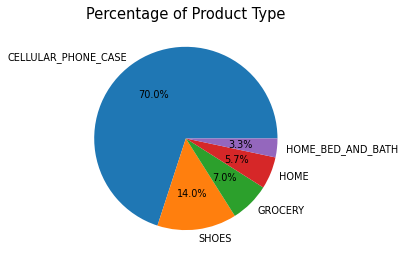

In [ ]:
plt.figure(figsize = (20, 10))

plt.subplots_adjust(left = 0, bottom = 0.5, right = 0.9, top = 0.9, wspace = 0.5, hspace = 0.8)

plt.subplot(141)

plt.title("Percentage of Product Type", fontsize = 15)

df2["product_type"].value_counts().plot.pie(autopct = "%1.1f%%", ylabel = "")

<a name="Product-Colors"></a>
### Product Colors

#### Top five frequency product colors

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


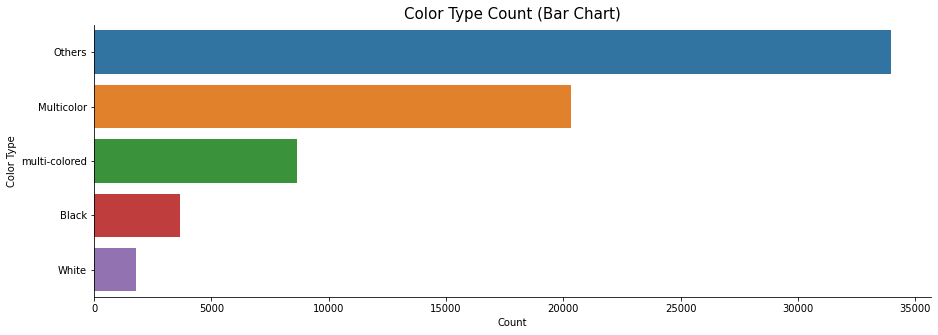

In [ ]:
top5_color = listing_data_with_image['color'].value_counts()[:5]
df3 = listing_data_with_image[listing_data_with_image['color'].isin(top5_color.index)]
fig, ax = plt.subplots()
fig.set_size_inches(15, 5)
sns.barplot(top5_color.values, top5_color.index)
ax.set_xlabel('Count', fontsize = 10)
ax.set_ylabel('Color Type', fontsize = 10)
ax.set_title('Color Type Count (Bar Chart)', fontsize = 15)
ax.tick_params(labelsize = 10)
sns.despine()

######Based on the bar chart, Other colors are the most frequency to compare others, which is 35,000

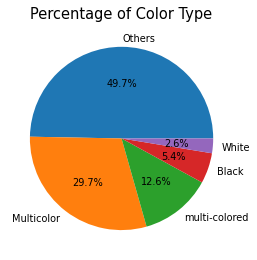

In [ ]:
plt.figure(figsize = (20, 10))

plt.subplots_adjust(left = 0, bottom = 0.5, right = 0.9, top = 0.9, wspace = 0.5, hspace = 0.8)

plt.subplot(141)

plt.title("Percentage of Color Type", fontsize = 15)

df3["color"].value_counts().plot.pie(autopct = "%1.1f%%", ylabel = "")

###### "Others" category is the largest proportion in color type to compare others.

<a name="Countries"></a>
### Countries

#### Top five frequency countries

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


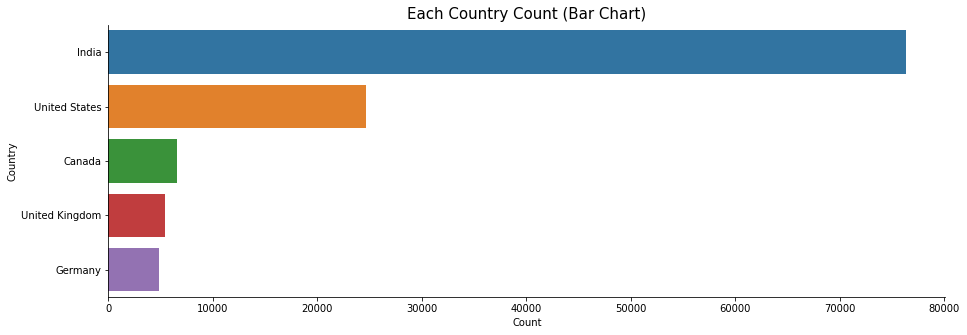

In [ ]:
top5_country = listing_data_with_image['country'].value_counts()[:5]
top5_country = top5_country.rename({'IN': 'India', 'US' : 'United States', 'CA': 'Canada', 'GB' : 'United Kingdom','DE': 'Germany'})
df4 = listing_data_with_image[listing_data_with_image['country'].isin(top5_country.index)]
fig, ax = plt.subplots()
fig.set_size_inches(15, 5)
sns.barplot(top5_country.values, top5_country.index)
ax.set_xlabel('Count', fontsize = 10)
ax.set_ylabel('Country', fontsize = 10)
ax.set_title('Each Country Count (Bar Chart)', fontsize = 15)
ax.tick_params(labelsize = 10)
sns.despine()

###### Based on the bar chart, India is the highest frequency in the Country's Category, with there are 64.8% of Market Share.

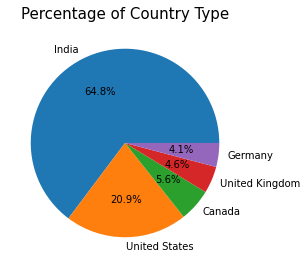

In [ ]:
plt.figure(figsize = (20, 10))

plt.subplots_adjust(left = 0, bottom = 0.5, right = 0.9, top = 0.9, wspace = 0.5, hspace = 0.8)

plt.subplot(141)

plt.title("Percentage of Country Type", fontsize = 15)

top5_country.plot.pie(autopct = "%1.1f%%", ylabel = "")

<a name="Marketplace"></a>
### Marketplace

#### Top five frequency marketplace

In [ ]:
listing_data_with_image.marketplace.value_counts()

Amazon                140954
PrimeNow                2368
AmazonFresh             2011
WholeFoods              1179
AmazonGo                 598
AmazonDistribution         9
Woot                       8
Name: marketplace, dtype: int64

##### Based on the Marketplace bar chart, Amazon is the highest frequency marketplace compared to others, with 95.8% market share

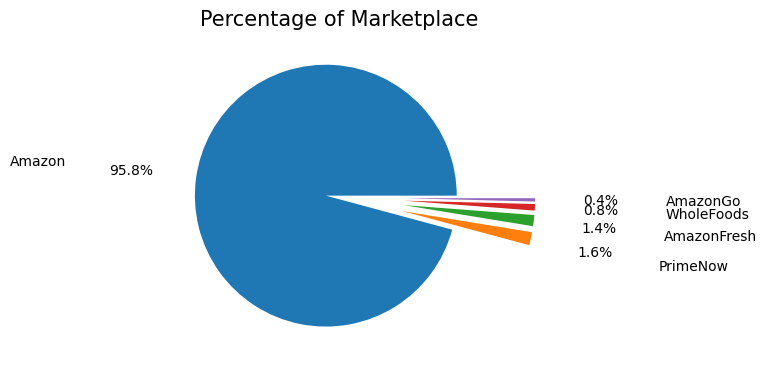

In [ ]:
top5_market = listing_data_with_image['marketplace'].value_counts()[:5]
df5 = listing_data_with_image[listing_data_with_image['marketplace'].isin(top5_market.index)]
plt.figure(figsize = (20, 10))

plt.subplots_adjust(left = 0, bottom = 0.5, right = 0.9, top = 0.9, wspace = 0.5, hspace = 0.8)
plt.subplot(141)
plt.title("Percentage of Marketplace", fontsize = 15)

df5["marketplace"].value_counts().plot.pie(autopct = "%1.1f%%", pctdistance = 1.5, labeldistance = 2, ylabel = "",
                                               xlabel = "", explode=[0.1, 0.5, 0.5, 0.5, 0.5])
plt.show()

<a name="Image-Embedding"></a>
## Image Embedding - Feature Extraction

[Embedding](https://answerstoall.com/miscellaneous/what-does-it-mean-to-embed-an-image/ "Click on"): 
  1. It is the integration of links, images, videos, GIFs and other content into social media posts or other online media. Embedded content appears as part of the post and provides a visual element that encourages increased click-through rates and engagement.

#### Resnet 50
For our project, we apply pretrained Restnet 50 for image embedding.

Resnet 50 is deep learning model applying convolutional nerual networks that commonly used in image classification. ResNet-50 has 50 layers deep and is trained on a million images of 1000 categories from the ImageNet database. Since it is a deep architecture model that requires over 23 million trained parameters, it is not feasible for us to build it from sratch. Therefore, using a pretained model is highly effective. 



We will use several packages to utilize the embedding model:

1. [Tensorflow](https://www.tensorflow.org/ "Click on"):
  * It is an end-to-end open source platform for machine learning. And it has a comprehensive, flexible ecosystem of tools, libraries, and community resources that enables researchers to push the state of the art in ML, and developers to easily build and deploy ML-based applications.
  * In the cloud, broswer or device, it is easy to train and deploy models.
  * A flexible and simple architecture to take new ideas from concept to code.

2. [Keras](https://keras.io/ "Click on"):
  * Keras is one of the best practices for reducing cognitive load: it provides a consistent and simple API, minimizes the number of user actions required for common use cases, and provides clear and actionable error messages. It also has extensive documentation and developer guides.

In [ ]:
import tensorflow as tf
import keras
from keras import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import GlobalMaxPooling2D
from sklearn.model_selection import train_test_split
tf.__version__

'2.8.0'

In [ ]:
# Split Train and Test
X_train, X_test, y_train, y_test = train_test_split(listing_data_with_image.drop(['product_type'], axis = 1), listing_data_with_image['product_type'], test_size=0.33, random_state=42)

##### Download Pretrained ResNet 50 from tensorflow：

In [ ]:
img_width, img_height = 256, 256
base_model = ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_shape = (img_width, img_height, 3))

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
model = keras.Sequential([
    base_model,
    GlobalMaxPooling2D()
])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_max_pooling2d (Globa  (None, 2048)             0         
 lMaxPooling2D)                                                  
                                                                 
Total params: 23,587,712
Trainable params: 23,534,592
Non-trainable params: 53,120
_________________________________________________________________


### Apply ResNet 50 to image data for feature extraction:

Due to high volume of images in Amazon Dataset, to get image embeding will cost us more than 10 hours, we decided to use subset of the image data to illustrate our idea and show how it works for image classification.

We sub sampled 15% of each product type from original listing data along with images since it can prserve the orginial distribution of the listing data. The total number of 15,347 images are applied for image embedings. 

In [ ]:
def get_embedding(model, img_name):
    # Reshape
    img = image.load_img(default_path + img_name, target_size=(img_width, img_height))
    # img to Array
    x   = image.img_to_array(img)
    # Expand Dim (1, w, h)
    x   = np.expand_dims(x, axis=0)
    # Pre process Input
    x   = preprocess_input(x)
    return model.predict(x).reshape(-1)

In [ ]:
top_10_cat = listing_data_with_image['product_type'].value_counts()[:10].index
top_10_cat_listing = listing_data_with_image[listing_data_with_image['product_type'].isin(top_10_cat)]


In [ ]:
top_10_cat_listing_sub = top_10_cat_listing.groupby('product_type').sample(frac = 0.15)
top_10_cat_listing_sub.head(3)

,brand,color,item_id,item_name,product_type,country,marketplace,main_image_id,image_id,height,width,path
142905,find.,Black Smart Black Smart Black,B07THKW5MD,"find. Arthur Classic Boots, Smart Black), 9 UK",BOOT,CA,Amazon,811TIa9fL6L,811TIa9fL6L,2560.0,1970.0,59/59fa1cab.jpg
54459,find.,Blue (Navy),B01MT7QN5F,Amazon Brand - find. Men’s Suede Casual Desert...,BOOT,CA,Amazon,81owqgdMemL,81owqgdMemL,2560.0,1969.0,79/79c42207.jpg
53554,find.,Negro Black,B0734SPS3N,find. Botines Perfilados con Puntera para Muje...,BOOT,ES,Amazon,71qSi-UV0qL,71qSi-UV0qL,2560.0,1969.0,cf/cf180779.jpg


The distribution of subsample listing data:



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


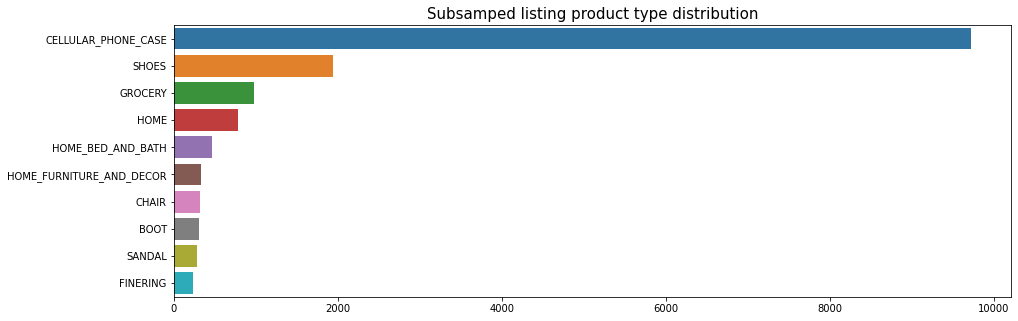

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 5)

sub_data = top_10_cat_listing_sub['product_type'].value_counts()
ax.set_title('Subsamped listing product type distribution', fontsize = 15)
sns.barplot(sub_data.values, sub_data.index)

In [ ]:
emb_1 = pd.DataFrame(columns = ['main_image_id', 'item_id', 'path'])
emb_1 = top_10_cat_listing_sub[['main_image_id', 'item_id', 'path']]
emb_1.head(3)

,main_image_id,item_id,path
142905,811TIa9fL6L,B07THKW5MD,59/59fa1cab.jpg
54459,81owqgdMemL,B01MT7QN5F,79/79c42207.jpg
53554,71qSi-UV0qL,B0734SPS3N,cf/cf180779.jpg


#### Get image embedding by using ResNet 50 

We obtained the feature embedding with 2048 features to represent each image. The following cell will take several hours to run. Please see below for faster access.


In [ ]:
# emb1_1  = emb_1['path'].apply(lambda x: get_embedding(model, x))
# df_emb = emb1_1.apply(pd.Series)
# print(df_emb.shape)
# df_emb.head()

(15347, 2048)


,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
83602,2.068263,3.127878,1.258705,3.598563,5.781941,6.113370,6.535263,16.167847,1.754082,4.881451,...,2.067807,0.000000,2.676741,0.000000,2.446908,0.636927,6.770893,2.117285,11.052140,1.808091
23510,2.573042,9.245814,3.197946,5.258088,17.917177,4.294720,9.564713,9.055824,4.398721,0.000000,...,5.626155,0.000000,3.235260,1.420073,5.486238,1.428541,16.271482,0.429905,2.840213,1.889900
5876,0.415602,8.521793,0.000000,0.670915,0.000000,5.344463,3.580968,3.544495,0.194432,0.000000,...,0.000000,1.907032,0.254144,2.065552,7.284829,3.114790,0.000000,0.848464,1.882259,2.682647
48430,0.227867,13.906814,0.672363,0.000000,7.280917,22.973446,1.560145,7.840107,3.656771,4.940603,...,1.538770,0.000000,0.543032,1.822608,0.583357,0.000000,6.076427,0.000000,1.350075,8.093085
71405,6.609721,5.277477,3.509688,2.329604,4.941103,9.317409,5.981090,1.160738,3.919087,0.461363,...,0.000000,2.577626,5.439342,1.122767,0.275872,5.315979,12.806154,4.470278,2.993828,10.030022


#### Read image embedding from Google Drive

Since the image embedding took several hours to run, we saved the embedding csv file in a shared Google Drive for saving time purpose. We provide a Google Drive link below for you to download. 

[embeding data](https://drive.google.com/file/d/1MIc_vBaJkh-433D--C7ipWSyTqrbO_mW/view?usp=sharing "Click on") 

In [ ]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [ ]:
downloaded = drive.CreateFile({'id':'1MIc_vBaJkh-433D--C7ipWSyTqrbO_mW'}) 
downloaded.GetContentFile('embedding.csv')  
df_emb_new = pd.read_csv('embedding.csv')
df_emb_new.head(3)

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,2.068263,3.127878,1.258706,3.598563,5.781941,6.113370,6.535263,16.167847,1.754082,4.881451,...,2.067807,0.000000,2.676741,0.000000,2.446908,0.636927,6.770893,2.117285,11.052140,1.808091
1,2.573042,9.245814,3.197946,5.258088,17.917177,4.294720,9.564713,9.055824,4.398721,0.000000,...,5.626155,0.000000,3.235260,1.420073,5.486238,1.428541,16.271482,0.429905,2.840213,1.889900
2,0.415602,8.521793,0.000000,0.670915,0.000000,5.344463,3.580968,3.544495,0.194432,0.000000,...,0.000000,1.907032,0.254144,2.065552,7.284829,3.114790,0.000000,0.848464,1.882259,2.682647


In [ ]:
df_emb_new.shape

(15347, 2048)

<a name="Get-Recommendations"></a>
## Get Recommendations


In this project, we will be building a **Content-based recommendation system** for users. Content-based recommendation recommends items based on additional information about the product/items by finding the most similar products to a given product based on the content. In this project we will find the most similar product based on the image embedding content. 

### **Cosine Similarity**

#### Cosine similarity is a measure of similarity between 2 vectors of an inner product space. It can be used in areas such as data mining, plagiarism detector, documents and recommendation systems. The basic logic behind is that it measures the cosine angle between 2 vectors in a multidimensional space and find the ones with the highest similarity index.

#### We will be applying cosine similarity on the image beddings we have created using Convolutional Neural Network ResNet 50 to obtain a similarity score matrix.

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances
cosine_sim = 1-pairwise_distances(df_emb_new, metric='cosine')
cosine_sim[:4, :4]

array([[1.        , 0.76775726, 0.64447332, 0.72104667],
       [0.76775726, 1.        , 0.67368997, 0.72889427],
       [0.64447332, 0.67368997, 1.        , 0.75222442],
       [0.72104667, 0.72889427, 0.75222442, 1.        ]])

In [ ]:
# indices
indices = pd.Series(range(len(df_emb_new)), index=df_emb_new.index)

# map indices to path index
path_index_map = dict()
for i in indices:
  path_index_map[i] = top_10_cat_listing_sub.index[i]

# Function that get image recommendations based on the cosine similarity score of image category
def get_recommender(idx, df_emb_new, top_n = 10):
    sim_idx    = indices[idx]
    sim_scores = list(enumerate(cosine_sim[sim_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    idx_rec    = [i[0] for i in sim_scores]
    idx_sim    = [i[1] for i in sim_scores]
    return indices.iloc[idx_rec].index, idx_sim

Now that we have defined our recommender function, we can use it to return index of images similar to the image user is currently browsing. Below we have computed top 10 image listings that are most similar to the item user is currently viewing. 

Using this concept, users will be able to enter a item index that represent the product he/she is currently browsing and get 10 recommended similar products based on information of the current product. 

In the example below, we can see that based on the brown shoe image information the user is currently browsing , we have returned 10 show recommendations for the user.

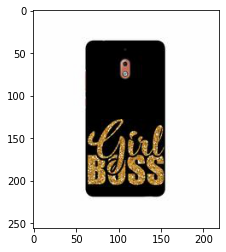

In [ ]:
# Idx Item to Recommender
# Recommendations
# idx_ref = 13688
idx_ref = 5274

idx_rec, idx_sim = get_recommender(idx_ref, df_emb_new, top_n = 10)

default_path = '/content/smallpics/images/small/'
rec_pics = top_10_cat_listing_sub['path'][path_index_map[idx_ref]]
image = img.imread(default_path+rec_pics)
plt.imshow(image)

For the given image above, we have the following 10 images that similiarto it.

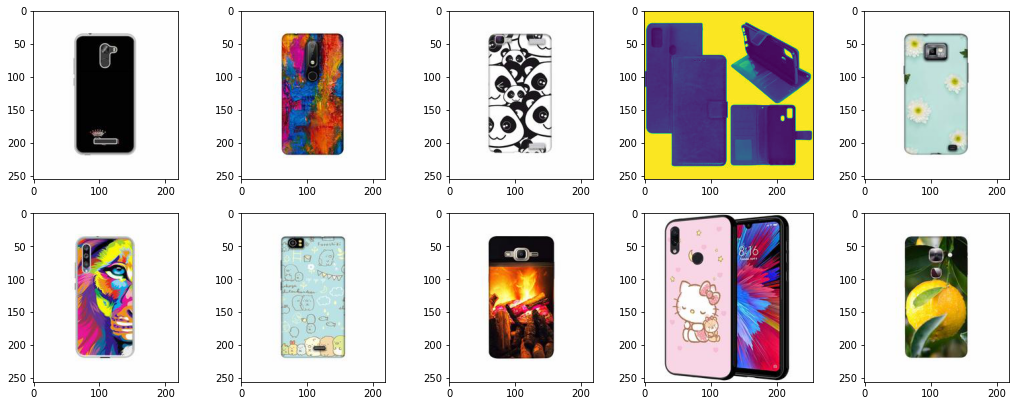

In [ ]:
fig = plt.figure(figsize=(18,18))
for idx,i in enumerate(idx_rec):
  fig.add_subplot(5,5,idx+1)
  pics = top_10_cat_listing_sub['path'][path_index_map[i]]
  image = img.imread(default_path+pics)
  plt.imshow(image)
plt.show()

Below shows that product listing information regarding to the given image.

In [ ]:
top_10_cat_listing_sub.iloc[idx_rec]

,brand,color,item_id,item_name,product_type,country,marketplace,main_image_id,image_id,height,width,path
63752,Amazon Brand - Solimo,Multicolor,B0853X77WN,Amazon Brand - Solimo Designer Queen UV Printe...,CELLULAR_PHONE_CASE,IN,Amazon,61xB9W9JhqL,61xB9W9JhqL,2200.0,1879.0,1e/1eb32ec9.jpg
16196,Amazon Brand - Solimo,Others,B07TCWTQR3,Amazon Brand - Solimo Designer Dark Multicolor...,CELLULAR_PHONE_CASE,IN,Amazon,81QM9udHDUL,81QM9udHDUL,2200.0,1879.0,65/65c914ce.jpg
55660,Amazon Brand - Solimo,Others,B07TB52VZD,Amazon Brand - Solimo Designer Panda Texture 3...,CELLULAR_PHONE_CASE,IN,Amazon,71MkQZNP0PL,71MkQZNP0PL,2200.0,1879.0,c8/c8c20e65.jpg
107401,Amazon Brand - Solimo,Black,B083P7NVXR,Amazon Brand - Solimo Flip Leather Mobile Cove...,CELLULAR_PHONE_CASE,IN,Amazon,61ML7YNiSeL,61ML7YNiSeL,1100.0,1100.0,66/6603514b.jpg
24267,Amazon Brand - Solimo,Others,B07T9TKWT1,Amazon Brand - Solimo Designer Flower Texture ...,CELLULAR_PHONE_CASE,IN,Amazon,610B6uH4qcL,610B6uH4qcL,2200.0,1879.0,8b/8b20d11f.jpg
33520,Amazon Brand - Solimo,Multicolor,B08547NTGT,Amazon Brand - Solimo Designer Funny Cat Patte...,CELLULAR_PHONE_CASE,IN,Amazon,71SYVeXSRKL,71SYVeXSRKL,2200.0,1879.0,b8/b8772e24.jpg
64476,Amazon Brand - Solimo,Multicolor,B0853XJZVQ,Amazon Brand - Solimo Designer Random UV Print...,CELLULAR_PHONE_CASE,IN,Amazon,71IHG3Hz93L,71IHG3Hz93L,2200.0,1879.0,57/5725a7e5.jpg
92554,Amazon Brand - Solimo,Others,B07TG4P77L,Amazon Brand - Solimo Designer Born Fire 3D Pr...,CELLULAR_PHONE_CASE,IN,Amazon,71ykbLK9WvL,71ykbLK9WvL,2200.0,1879.0,e1/e15e5c2c.jpg
73300,Amazon Brand - Solimo,multi-colored,B07RCN7WD2,Amazon Brand - Solimo Designer Kitty Printed H...,CELLULAR_PHONE_CASE,IN,Amazon,61s192c5FCL,61s192c5FCL,1000.0,1000.0,25/25721ea1.jpg
66555,Amazon Brand - Solimo,Others,B07TF1BJYX,Amazon Brand - Solimo Designer Lemon 3D Printe...,CELLULAR_PHONE_CASE,IN,Amazon,71JGC0iwORL,71JGC0iwORL,2200.0,1879.0,bd/bde75858.jpg
